<a href="https://colab.research.google.com/github/sunilvengalil/BloodVesselSegment/blob/master/fundal_image_seg_demo_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simultaneous prediction of Optic Disc and Blood vessels using a single multi-tasking deep learning model**

## 1. Deep Learning Model Architecture



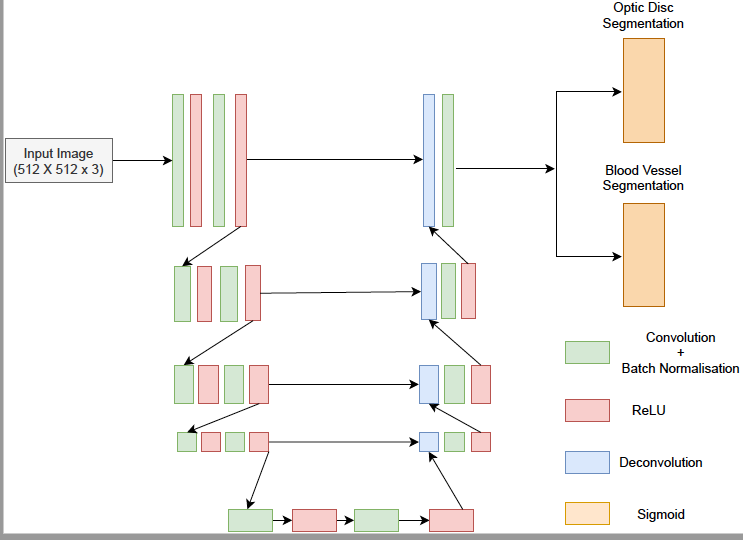



## 2. Upload wheel file and install package `fundal_image` using the steps below

### a) Download the file [fundal_image-1.0-py3-none-any.whl](https://drive.google.com/file/d/15U5SbdRQ-7j7OR-9ezr4ibbyILKzj7S_/view?usp=sharing)  to your local computer and upload to the google colab VM using the steps given below. By default the file gets uploaded to `/content` directory 
>Click on the `files` icon file_icon.png on the left panel in google colab, click on the `upload` icon ladder_network 2021-08-07 at 11.49.26 AM.png
and select the file to upload from your local computer.

(Alternately one can drag and drop the file from local folder to the empty space in the left pane)

In [1]:
!pwd
!ls

/content
sample_data


### b) Run the below cell to install the `fundal_image `package


In [ ]:
!pip install /content/fundal_image-1.0-py3-none-any.whl --force-reinstall

Processing ./fundal_image-1.0-py3-none-any.whl
  Attempting uninstall: fundal-image
    Found existing installation: fundal-image 1.0
    Uninstalling fundal-image-1.0:
      Successfully uninstalled fundal-image-1.0


##3. Import required packages

In [ ]:
import os
from tqdm import tqdm
from glob import glob
import numpy as np
from sklearn.utils import shuffle
import cv2
from PIL import Image

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, AUC

from google.colab import drive
from matplotlib import pyplot as plt
% matplotlib inline

from albumentations import HorizontalFlip, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion
from fundal_image.utils import create_data, create_dir, get_filenames_sorted, generate_od_and_bv_gt

##4. Generate data

### a) Download DRIVE test dataset from [here](https://drive.google.com/file/d/18y44Y-u96qzeQ6E2NmTHi8vMqFTth1eL/view?usp=sharing), upload it to google colab (Follow the step 1 in above section) and unzip it by running below cell

In [ ]:
!unzip drive.zip

Archive:  drive.zip
   creating: drive/
  inflating: drive/.DS_Store         
  inflating: __MACOSX/drive/._.DS_Store  
   creating: drive/test/
  inflating: __MACOSX/drive/._test   
  inflating: drive/test/.DS_Store    
  inflating: __MACOSX/drive/test/._.DS_Store  
   creating: drive/test/1st_manual/
  inflating: __MACOSX/drive/test/._1st_manual  
   creating: drive/test/images/
  inflating: __MACOSX/drive/test/._images  
   creating: drive/test/od_annotations/
   creating: drive/test/mask/
  inflating: __MACOSX/drive/test/._mask  
   creating: drive/test/2nd_manual/
  inflating: __MACOSX/drive/test/._2nd_manual  
  inflating: drive/test/1st_manual/16_manual1.gif  
  inflating: __MACOSX/drive/test/1st_manual/._16_manual1.gif  
  inflating: drive/test/1st_manual/03_manual1.gif  
  inflating: __MACOSX/drive/test/1st_manual/._03_manual1.gif  
  inflating: drive/test/1st_manual/06_manual1.gif  
  inflating: __MACOSX/drive/test/1st_manual/._06_manual1.gif  
  inflating: drive/test/1st_man

###b)  Verify that the drive test image files are present in the folder `drive`

In [ ]:
!ls drive/test/images
!ls drive/test/od_annotations
!ls drive/test/mask
!ls drive/test/1st_manual
!ls drive/test/2nd_manual


01_test.tif  05_test.tif  09_test.tif  13_test.tif  17_test.tif
02_test.tif  06_test.tif  10_test.tif  14_test.tif  18_test.tif
03_test.tif  07_test.tif  11_test.tif  15_test.tif  19_test.tif
04_test.tif  08_test.tif  12_test.tif  16_test.tif  20_test.tif
01_test.tif  05_test.tif  09_test.tif  13_test.tif  17_test.tif
02_test.tif  06_test.tif  10_test.tif  14_test.tif  18_test.tif
03_test.tif  07_test.tif  11_test.tif  15_test.tif  19_test.tif
04_test.tif  08_test.tif  12_test.tif  16_test.tif  20_test.tif
01_test_mask.gif  06_test_mask.gif  11_test_mask.gif  16_test_mask.gif
02_test_mask.gif  07_test_mask.gif  12_test_mask.gif  17_test_mask.gif
03_test_mask.gif  08_test_mask.gif  13_test_mask.gif  18_test_mask.gif
04_test_mask.gif  09_test_mask.gif  14_test_mask.gif  19_test_mask.gif
05_test_mask.gif  10_test_mask.gif  15_test_mask.gif  20_test_mask.gif
01_manual1.gif	05_manual1.gif	09_manual1.gif	13_manual1.gif	17_manual1.gif
02_manual1.gif	06_manual1.gif	10_manual1.gif	14_manual1.gi

#5. Check the quality of the image TODO get code from Ammu

In [ ]:
data_set_base_path = "/content/drive/"
dataset = "test"
drive_od_test_path = data_set_base_path + dataset
image_path = f"{drive_od_test_path}/images/"

fontdict = {"fontsize":22}

(-0.5, 564.5, 583.5, -0.5)

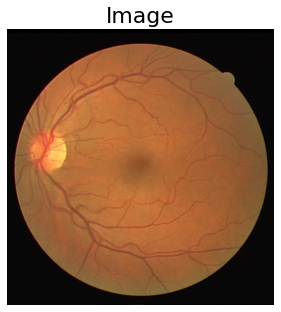

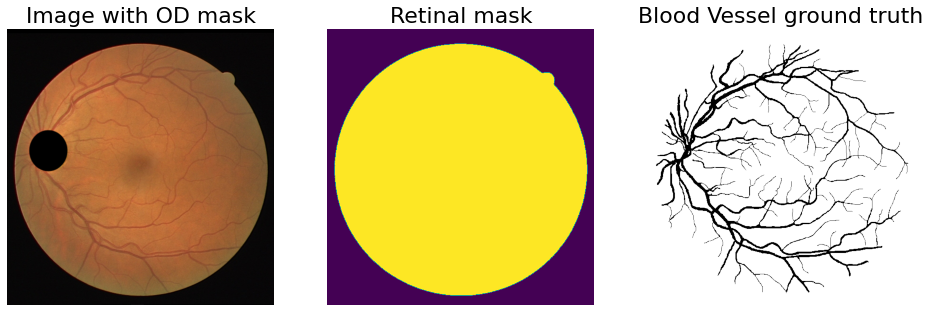

In [ ]:

num_rows, num_cols = 1, 4
image_no = 1
fig = plt.figure(figsize=(22, 10))

fig.add_subplot(num_rows, num_cols, image_no)
im = np.asarray(Image.open(f"{image_path}/01_test.tif"))
plt.imshow(im)
plt.title("Image", fontdict=fontdict)
plt.axis("off")

fig = plt.figure(figsize=(22, 10))

image_no += 1
fig.add_subplot(num_rows, num_cols, image_no)
im = Image.open("/content/drive/test/od_annotations/01_test.tif")
plt.imshow(np.asarray(im))
plt.title("Image with OD mask", fontdict=fontdict)
plt.axis("off")

image_no += 1
fig.add_subplot(num_rows, num_cols, image_no)
im = Image.open("/content/drive/test/mask/01_test_mask.gif")
plt.imshow(np.asarray(im))
plt.title("Retinal mask", fontdict=fontdict)
plt.axis("off")

image_no += 1
fig.add_subplot(num_rows, num_cols, image_no)
im = np.asarray(Image.open("/content/drive/test/1st_manual/01_manual1.gif"))
plt.imshow(im, cmap="Greys")
plt.title("Blood Vessel ground truth", fontdict=fontdict)
plt.axis("off")

###c) Combine OD and Blood Vessel Ground Truth into one single image. Blood vessel in green and OD in blue

In [ ]:
bv_directory = f"{drive_od_test_path}/1st_manual/"
od_directory = f"{drive_od_test_path}/od_gt_final/"
mask_directory = f"{drive_od_test_path}/mask/"
out_directory = f"{drive_od_test_path}/od_and_bv_gt_combined/"


generate_od_and_bv_gt(od_gt_path = f"{drive_od_test_path}/od_annotations/",
                      bv_gt_path=bv_directory,
                      output_path = out_directory,
                      mask_path = mask_directory
                      )

Reading from file /content/drive/test/od_annotations/01_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations/02_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations/03_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations/04_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations/05_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations/06_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations/07_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations/08_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations/09_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations/10_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations/11_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations/12_test.tif
(584, 565, 3)
Reading from file /content/drive/test/od_annotations

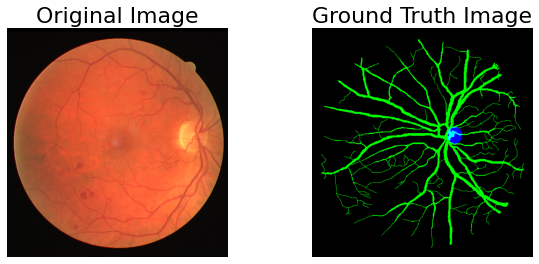

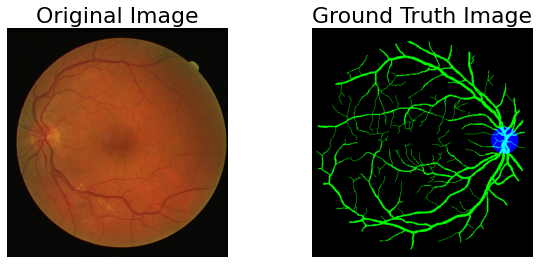

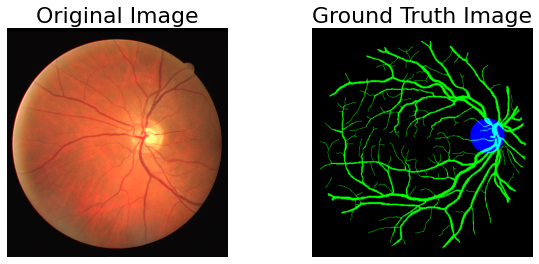

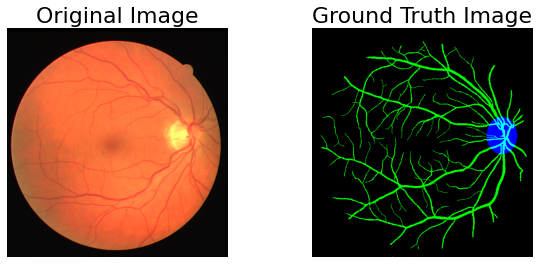

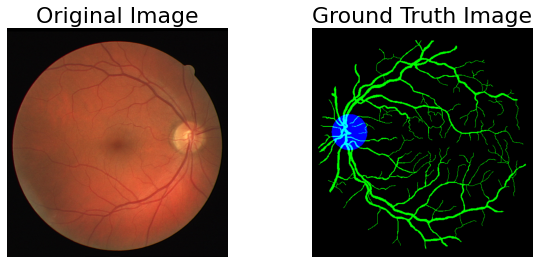

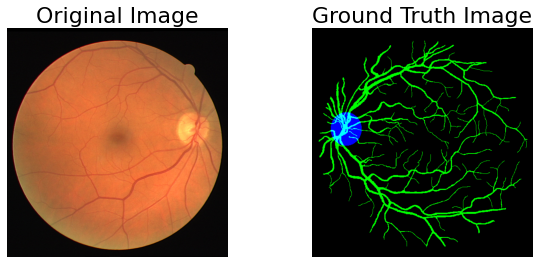

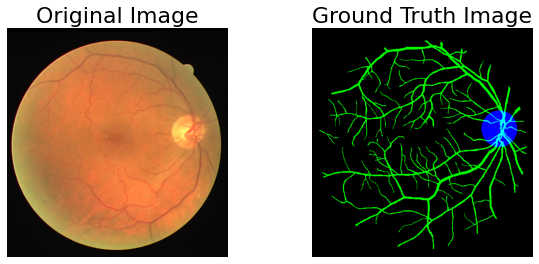

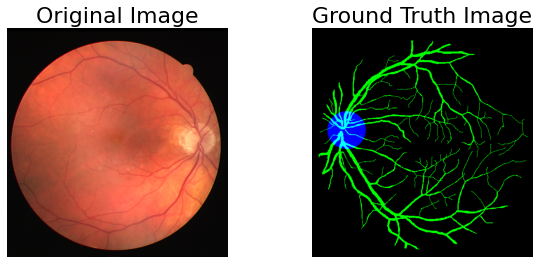

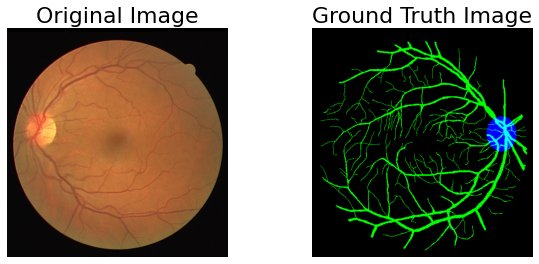

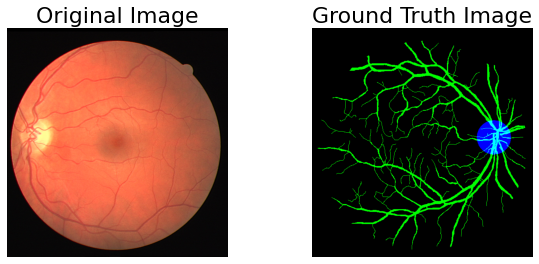

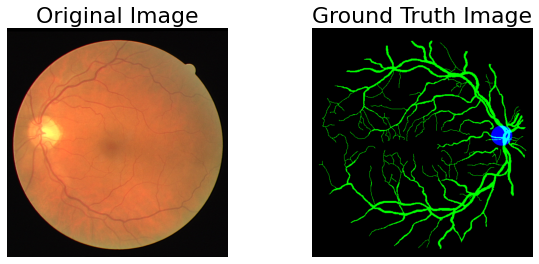

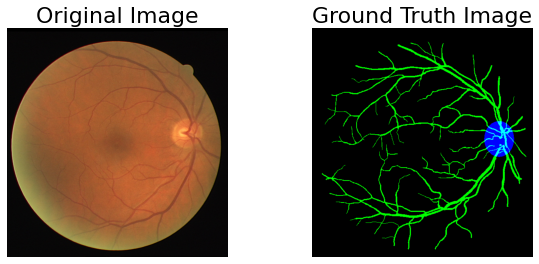

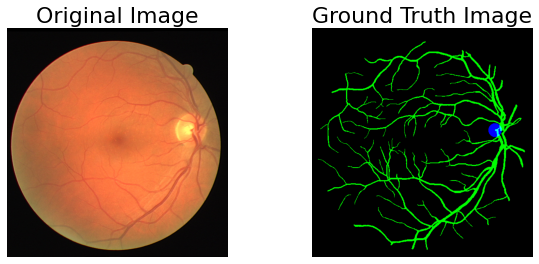

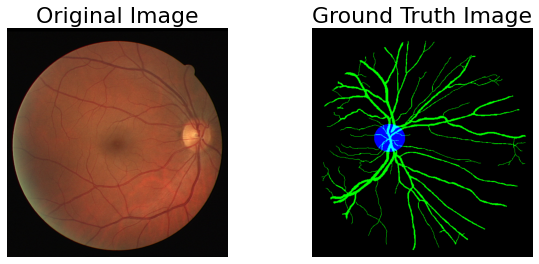

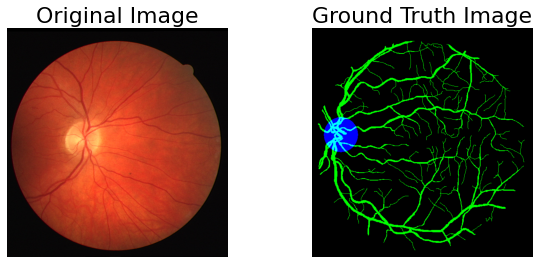

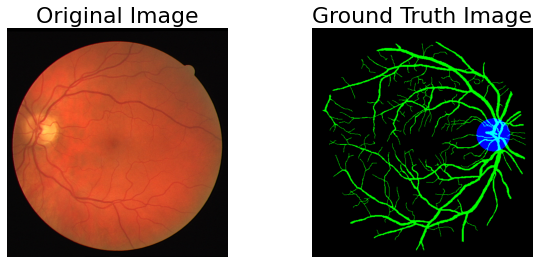

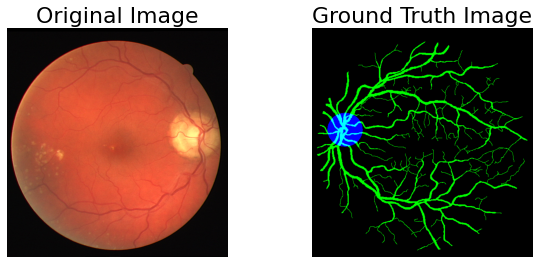

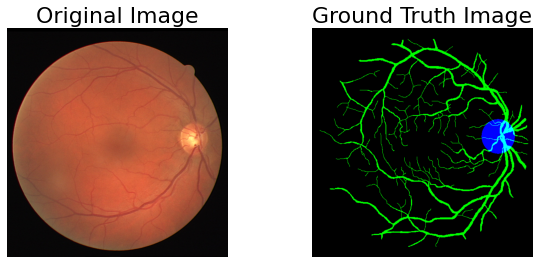

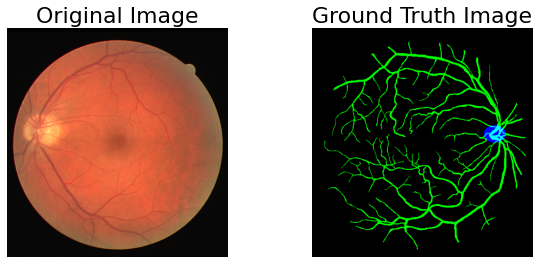

In [ ]:
gt_path = out_directory
files = os.listdir(gt_path)
for im_file, gt_file in zip(os.listdir(image_path), files):
    if im_file.startswith("."):
        continue
    fig = plt.figure(figsize=(10, 100))
    fig.add_subplot(len(files), 2, 1)
    im = np.asarray(Image.open(f"{image_path}/{im_file}"))
    plt.imshow(im)
    plt.title("Original Image",fontdict=fontdict)
    plt.axis("off")

    fig.add_subplot(len(files), 2, 2)
    gt = np.asarray(Image.open(f"{gt_path}/{gt_file}"))
    plt.imshow(gt)
    plt.title("Ground Truth Image", fontdict=fontdict)
    plt.axis("off")


###d) Resize input images and ground truth to size 512 X 512


In [ ]:
data_dir = "/content/data_for_prediction"

In [ ]:
np.random.seed(42)
""" Creating directories """
create_dir(f"{data_dir}/test/image")
create_dir(f"{data_dir}/test/mask")

(test_x_files, test_y_files) = get_filenames_sorted(data_set_base_path + "test/images/",
                                                    data_set_base_path + "test/od_and_bv_gt_combined/"
                                                    )

print(f"Test: {len(test_x_files)} - {len(test_y_files)}")

create_data(test_x_files, test_y_files, f"{data_dir}/test/", augment=False)


 15%|█▌        | 3/20 [00:00<00:00, 27.47it/s]

Test: 20 - 20
/content/drive/test/images/01_test.tif /content/drive/test/od_and_bv_gt_combined/01_test.png
name 01_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/01_test.png
/content/drive/test/images/02_test.tif /content/drive/test/od_and_bv_gt_combined/02_test.png
name 02_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/02_test.png
/content/drive/test/images/03_test.tif /content/drive/test/od_and_bv_gt_combined/03_test.png
name 03_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/03_test.png
/content/drive/test/images/04_test.tif /content/drive/test/od_and_bv_gt_combined/04_test.png
name 04_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/04_test.png
/content/drive/test/images/05_test.tif /content/drive/test/od_and_bv_gt_combined/05_test.png
name 05_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/05_test.png
/

 45%|████▌     | 9/20 [00:00<00:00, 27.88it/s]

/content/drive/test/images/07_test.tif /content/drive/test/od_and_bv_gt_combined/07_test.png
name 07_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/07_test.png
/content/drive/test/images/08_test.tif /content/drive/test/od_and_bv_gt_combined/08_test.png
name 08_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/08_test.png
/content/drive/test/images/09_test.tif /content/drive/test/od_and_bv_gt_combined/09_test.png
name 09_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/09_test.png
/content/drive/test/images/10_test.tif /content/drive/test/od_and_bv_gt_combined/10_test.png
name 10_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/10_test.png
/content/drive/test/images/11_test.tif /content/drive/test/od_and_bv_gt_combined/11_test.png
name 11_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/11_test.png
/content/drive/

 75%|███████▌  | 15/20 [00:00<00:00, 28.01it/s]

/content/drive/test/images/13_test.tif /content/drive/test/od_and_bv_gt_combined/13_test.png
name 13_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/13_test.png
/content/drive/test/images/14_test.tif /content/drive/test/od_and_bv_gt_combined/14_test.png
name 14_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/14_test.png
/content/drive/test/images/15_test.tif /content/drive/test/od_and_bv_gt_combined/15_test.png
name 15_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/15_test.png
/content/drive/test/images/16_test.tif /content/drive/test/od_and_bv_gt_combined/16_test.png
name 16_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/16_test.png
/content/drive/test/images/17_test.tif /content/drive/test/od_and_bv_gt_combined/17_test.png
name 17_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/17_test.png
/content/drive/

100%|██████████| 20/20 [00:00<00:00, 27.76it/s]

/content/drive/test/images/19_test.tif /content/drive/test/od_and_bv_gt_combined/19_test.png
name 19_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/19_test.png
/content/drive/test/images/20_test.tif /content/drive/test/od_and_bv_gt_combined/20_test.png
name 20_test
(584, 565, 3) (584, 565, 3)
Saving to  /content/data_for_prediction/test/image/20_test.png


(-0.5, 511.5, 511.5, -0.5)

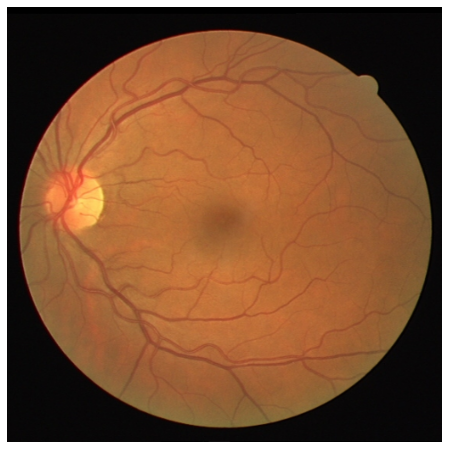

In [ ]:
from PIL import Image
im = Image.open( data_dir + "/test/image/01_test.png")
im = np.asarray(im)
plt.figure(figsize=(8,8))
plt.imshow(im)
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

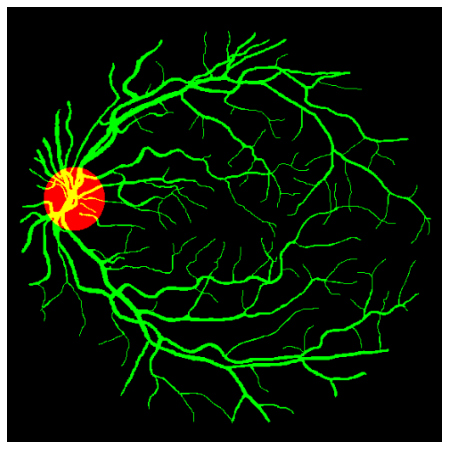

In [ ]:
im = cv2.imread( data_dir + "/test/mask/01_test.png")
plt.figure(figsize=(8,8))
plt.imshow(im)

plt.axis("off")

#6. Prediction

In [ ]:
import pandas as pd
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, auc


In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (512, 512)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = x[:,:,0:2] # Discard the last channel 
    return ori_x, x

def save_results(ori_x, ori_y, y_pred, save_image_path, channel):
    line = np.ones((y_pred.shape[0], 10, 3)) * 255
    pred_image = np.zeros((y_pred.shape[0], y_pred.shape[1], 3))
    _y_pred = y_pred[:, :, channel]
    _ori_y = ori_y[:, :, channel]
    pred_image[:, :, 0] = ((_y_pred > 0.5) & (_ori_y <= 128)) * 255
    pred_image[:, :, 1] = ((_y_pred > 0.5) & (_ori_y  > 128)) * 255
    pred_image[:, :, 2] = ((_ori_y  > 128) & (_y_pred <= 0.5 )) * 255

    print(" saving result", save_image_path)
    cv2.imwrite(save_image_path, pred_image)


###a) Mount the google drive for loading trained model

### or

###Download the trained model from [here](https://drive.google.com/file/d/1f7ZNsDf4Y0H86S636od_oWyYsAJJ1kFk/view?usp=sharing) and upload it as shown in step 1 in section 1(a)

In [ ]:
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/sunil/icvgip/
!pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/sunil/icvgip
/content/gdrive/MyDrive/sunil/icvgip


In [ ]:
# https://drive.google.com/drive/folders/1--9Nt2C3V0PuHLND5EkkjessSP1eXRe6?usp=sharing

In [ ]:
!ls /content/gdrive/MyDrive/sunil/icvgip/fundal_image/trained_models

model_combined.h5


In [ ]:
!pwd

/content/gdrive/MyDrive/sunil/icvgip


In [ ]:
!ls

concept_learning		 files_od_and_bv_weighted_demo_1_od
files_demo_bv			 fundal_image
files_demo_od			 medical_image_processing_old
files_od_and_bv_weighted_demo_1


In [ ]:
from copy import deepcopy

od_channel, bv_channel = 0, 1
od_result_dir = "files_demo_od"
bv_result_dir = "files_demo_bv"

create_dir(od_result_dir)
create_dir(bv_result_dir)

model_dir = "/content/gdrive/MyDrive/sunil/icvgip/fundal_image/trained_models"
""" Load the model """
model_file_name = f"{model_dir}/model_combined.h5"
print(model_file_name)
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model(model_file_name)

""" Load the dataset """
# dataset_path = os.path.join(data_dir, "test")
test_x, test_y = get_filenames_sorted(data_dir + "/test/image/", data_dir + "/test/mask/" )

""" Make the prediction and calculate the metrics values """
SCORE_BV, SCORE_OD = [], []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    """ Extracting name """
    name = x.rsplit("/", 1)[1].rsplit(".", 1)[0]
    print(name)

    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_mask(y)

    """ Prediction """
    y_pred = model.predict(np.expand_dims(x, axis=0))[0]
    y_pred_proba = deepcopy(y_pred)
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.float32)

    print(np.max(ori_y), np.max(y))

    """ Saving the images """
    save_image_path_od = f"{od_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_od, od_channel)

    save_image_path_bv = f"{bv_result_dir}/{name}.png"
    save_results(ori_x, ori_y, y_pred, save_image_path_bv, bv_channel)


#     """ Calculate the bv metrics """
    bv_pred = y_pred[:, :, bv_channel].flatten()
    bv_gt = y[:, :, bv_channel].flatten()
    acc_value = accuracy_score(bv_gt > 0.5, bv_pred>0.5)
    f1_value = f1_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    jac_value = jaccard_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    recall_value = recall_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    recall_computed = np.sum((bv_gt > 0.5) & (bv_pred > 0.5)) / np.sum(bv_gt > 0.5)
    precision_value = precision_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    # auc_score = auc(y_pred_proba[:, :, bv_channel].flatten(), bv_gt)
    SCORE_BV.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

#     """ Calculate the od metrics """
    bv_pred = y_pred[:, :, od_channel].flatten()
    bv_gt = y[:, :, od_channel].flatten()
    acc_value = accuracy_score(bv_gt > 0.5, bv_pred>0.5)
    f1_value = f1_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    jac_value = jaccard_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    recall_value = recall_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    recall_computed = np.sum((bv_gt > 0.5) & (bv_pred > 0.5)) / np.sum(bv_gt > 0.5)
    precision_value = precision_score(bv_gt > 0.5, bv_pred>0.5, labels=[0, 1], average="binary")
    SCORE_OD.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])
print("\n")
for SCORE in [SCORE_OD, SCORE_BV]:
    if SCORE == SCORE_OD:
        print("****** OD Metrics")
    else:
        print("****** BV Metrics")
    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f} (dice score)")
    # print(f"AUC: {score[1]:0.5f} (Auc score)")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    # """ Saving """
    if SCORE == SCORE_OD:
        od_df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard(IoU)", "Recall", "Precision"])
        od_df.to_csv(f"{od_result_dir}/score.csv")
    else:
        bv_df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard(IoU)", "Recall", "Precision"])
        bv_df.to_csv(f"{bv_result_dir}/score.csv")
    print("\n")


/content/gdrive/MyDrive/sunil/icvgip/fundal_image/trained_models/model_combined.h5


  0%|          | 0/20 [00:00<?, ?it/s]

01_test
255 1.0
 saving result files_demo_od/01_test.png
 saving result files_demo_bv/01_test.png


  5%|▌         | 1/20 [00:03<01:03,  3.32s/it]

02_test
255 1.0
 saving result files_demo_od/02_test.png
 saving result files_demo_bv/02_test.png


 10%|█         | 2/20 [00:06<00:57,  3.20s/it]

03_test
255 1.0
 saving result files_demo_od/03_test.png
 saving result files_demo_bv/03_test.png


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 15%|█▌        | 3/20 [00:09<00:53,  3.13s/it]

04_test
255 1.0
 saving result files_demo_od/04_test.png
 saving result files_demo_bv/04_test.png


 20%|██        | 4/20 [00:12<00:49,  3.07s/it]

05_test
255 1.0
 saving result files_demo_od/05_test.png
 saving result files_demo_bv/05_test.png


 25%|██▌       | 5/20 [00:15<00:45,  3.02s/it]

06_test
255 1.0
 saving result files_demo_od/06_test.png
 saving result files_demo_bv/06_test.png


 30%|███       | 6/20 [00:17<00:41,  2.99s/it]

07_test
255 1.0
 saving result files_demo_od/07_test.png
 saving result files_demo_bv/07_test.png


 35%|███▌      | 7/20 [00:20<00:38,  2.97s/it]

08_test
255 1.0
 saving result files_demo_od/08_test.png
 saving result files_demo_bv/08_test.png


 40%|████      | 8/20 [00:23<00:35,  2.95s/it]

09_test
255 1.0
 saving result files_demo_od/09_test.png
 saving result files_demo_bv/09_test.png


 45%|████▌     | 9/20 [00:26<00:32,  2.94s/it]

10_test
255 1.0
 saving result files_demo_od/10_test.png
 saving result files_demo_bv/10_test.png


 50%|█████     | 10/20 [00:29<00:29,  2.93s/it]

11_test
255 1.0
 saving result files_demo_od/11_test.png
 saving result files_demo_bv/11_test.png


 55%|█████▌    | 11/20 [00:32<00:26,  2.93s/it]

12_test
255 1.0
 saving result files_demo_od/12_test.png
 saving result files_demo_bv/12_test.png


 60%|██████    | 12/20 [00:35<00:23,  2.93s/it]

13_test
255 1.0
 saving result files_demo_od/13_test.png
 saving result files_demo_bv/13_test.png


 65%|██████▌   | 13/20 [00:38<00:20,  2.93s/it]

14_test
255 1.0
 saving result files_demo_od/14_test.png
 saving result files_demo_bv/14_test.png


 70%|███████   | 14/20 [00:41<00:17,  2.92s/it]

15_test
255 1.0
 saving result files_demo_od/15_test.png
 saving result files_demo_bv/15_test.png


 75%|███████▌  | 15/20 [00:44<00:14,  2.92s/it]

16_test
255 1.0
 saving result files_demo_od/16_test.png
 saving result files_demo_bv/16_test.png


 80%|████████  | 16/20 [00:47<00:11,  2.93s/it]

17_test
255 1.0
 saving result files_demo_od/17_test.png
 saving result files_demo_bv/17_test.png


 85%|████████▌ | 17/20 [00:50<00:08,  2.94s/it]

18_test
255 1.0
 saving result files_demo_od/18_test.png
 saving result files_demo_bv/18_test.png


 90%|█████████ | 18/20 [00:53<00:05,  2.95s/it]

19_test
255 1.0
 saving result files_demo_od/19_test.png
 saving result files_demo_bv/19_test.png


 95%|█████████▌| 19/20 [00:56<00:02,  2.96s/it]

20_test
255 1.0
 saving result files_demo_od/20_test.png
 saving result files_demo_bv/20_test.png


100%|██████████| 20/20 [00:59<00:00,  2.95s/it]



****** OD Metrics
Accuracy: 0.99205
F1: 0.71333 (dice score)
Jaccard: 0.62034
Recall: 0.84794
Precision: 0.71684


****** BV Metrics
Accuracy: 0.96400
F1: 0.77175 (dice score)
Jaccard: 0.63109
Recall: 0.71134
Precision: 0.86025




(-0.5, 511.5, 511.5, -0.5)

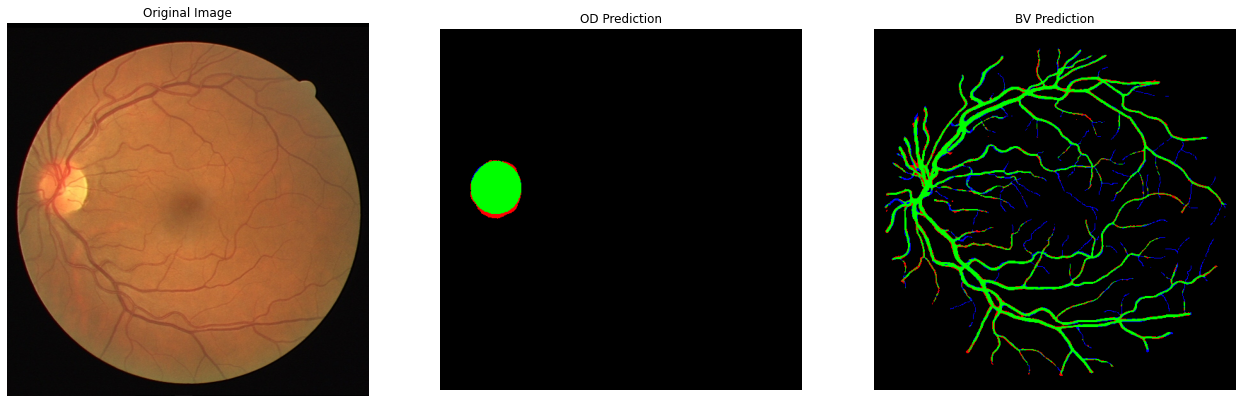

In [ ]:
for file in f"{image_path}/*.tif":
    fig = plt.figure(figsize=(22, 20))

    im = np.asarray(Image.open(file))
    fig.add_subplot(1, 3, 1)
    plt.imshow(im)
    plt.title("Original Image")
    plt.axis("off")

    file_prefix = file.rsplit(".", 1)[0].rsplit("/")[1]
    path = f"{od_result_dir}/"
    od_result_image = image_files(path, file_prefix)
    if len(od_result_image) == 0:
        raise Exception(f"File does not exist {od_result_image}")
    im = cv2.imread(od_result_image)

    fig.add_subplot(1, 3, 2)
    plt.imshow(im)
    plt.title("OD Prediction")
    plt.axis("off")

    im = cv2.imread(f"{bv_result_dir}/01_test.png")
    fig.add_subplot(1, 3, 3)
    plt.imshow(im)
    plt.title("BV Prediction")
    plt.axis("off")



In [ ]:
!pwd

/content/gdrive/My Drive/sunil/icvgip


In [ ]:
%cd ../..

/content/gdrive/My Drive


In [ ]:
%cd /content/drive/test/

/content/drive/test


In [ ]:
!ls

1st_manual  2nd_manual	images	mask  od_and_bv_gt_combined  od_annotations


In [ ]:
!zip od_and_bv_gt_combined.zip od_and_bv_gt_combined/*.*

  adding: od_and_bv_gt_combined/01_test.png (deflated 16%)
  adding: od_and_bv_gt_combined/02_test.png (deflated 16%)
  adding: od_and_bv_gt_combined/03_test.png (deflated 17%)
  adding: od_and_bv_gt_combined/04_test.png (deflated 15%)
  adding: od_and_bv_gt_combined/05_test.png (deflated 16%)
  adding: od_and_bv_gt_combined/06_test.png (deflated 16%)
  adding: od_and_bv_gt_combined/07_test.png (deflated 18%)
  adding: od_and_bv_gt_combined/08_test.png (deflated 18%)
  adding: od_and_bv_gt_combined/09_test.png (deflated 18%)
  adding: od_and_bv_gt_combined/10_test.png (deflated 20%)
  adding: od_and_bv_gt_combined/11_test.png (deflated 19%)
  adding: od_and_bv_gt_combined/12_test.png (deflated 18%)
  adding: od_and_bv_gt_combined/13_test.png (deflated 18%)
  adding: od_and_bv_gt_combined/14_test.png (deflated 17%)
  adding: od_and_bv_gt_combined/15_test.png (deflated 19%)
  adding: od_and_bv_gt_combined/16_test.png (deflated 19%)
  adding: od_and_bv_gt_combined/17_test.png (deflated 19

In [ ]:
!ls

1st_manual  images  od_and_bv_gt_combined      od_annotations
2nd_manual  mask    od_and_bv_gt_combined.zip


In [ ]:
!pwd

/content/drive/test


In [ ]:
!zip file_demo_od.zip /content/gdrive/MyDrive/sunil/icvgip/files_demo_od/*.*

  adding: content/gdrive/MyDrive/sunil/icvgip/files_demo_od/01_test.png (deflated 60%)
  adding: content/gdrive/MyDrive/sunil/icvgip/files_demo_od/02_test.png (deflated 56%)
  adding: content/gdrive/MyDrive/sunil/icvgip/files_demo_od/03_test.png (deflated 69%)
  adding: content/gdrive/MyDrive/sunil/icvgip/files_demo_od/04_test.png (deflated 57%)
  adding: content/gdrive/MyDrive/sunil/icvgip/files_demo_od/05_test.png (deflated 60%)
  adding: content/gdrive/MyDrive/sunil/icvgip/files_demo_od/06_test.png (deflated 59%)
  adding: content/gdrive/MyDrive/sunil/icvgip/files_demo_od/07_test.png (deflated 57%)
  adding: content/gdrive/MyDrive/sunil/icvgip/files_demo_od/08_test.png (deflated 52%)
  adding: content/gdrive/MyDrive/sunil/icvgip/files_demo_od/09_test.png (deflated 56%)
  adding: content/gdrive/MyDrive/sunil/icvgip/files_demo_od/10_test.png (deflated 62%)
  adding: content/gdrive/MyDrive/sunil/icvgip/files_demo_od/11_test.png (deflated 59%)
  adding: content/gdrive/MyDrive/sunil/icvg